In [2]:
#imports and check 
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
import seaborn as sns 
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPool2D,BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from keras.utils import np_utils

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
#metadata set based on images 
meta_data = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")
meta_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [4]:
skin_image_dir = "/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"

#make a copy of meta-datdjsu
df = meta_data.copy()

In [6]:
#check we got the right dir 
if os.path.exists(skin_image_dir):
    print(f"The directory '{skin_image_dir}' exists.")
    
    # check a few image files from the directory to confirm its contents
    image_files = [f for f in os.listdir(skin_image_dir) if f.endswith('.jpg')]
    
    # display the first few image filenames (for instance, the first 5)
    print("First few image files:")
    for img in image_files[:5]:
        print(img)
else:
    print(f"The directory '{skin_image_dir}' does not exist.")

The directory '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer' exists.
First few image files:
ISIC_0030912.jpg
ISIC_0028933.jpg
ISIC_0030585.jpg
ISIC_0028394.jpg
ISIC_0033697.jpg


In [7]:
#get ids and image path for df 
ids = [x.split('.')[0] for x in os.listdir(skin_image_dir)]
image_path = {x:os.path.join(skin_image_dir,f'{x}.jpg') for x in ids}

#lets make a dict that changes maps the abbreviations for dx - more easier to understand what we are looking at 
lesion_classes = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis lesions ',
    'bcc': 'BC carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular',
    'df': 'Dermatofibroma'
}


In [8]:
# renaming dx types to respective names
df['dx'] = df['dx'].map(lesion_classes)

# adding image files to path in respect to image_id 
df['img_dir'] = df['image_id'].map(image_path.get)

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,img_dir
0,HAM_0000118,ISIC_0027419,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
1,HAM_0000118,ISIC_0025030,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
2,HAM_0002730,ISIC_0026769,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
3,HAM_0002730,ISIC_0025661,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
4,HAM_0001466,ISIC_0031633,Benign keratosis lesions,histo,75.0,male,ear,/kaggle/input/skin-cancer-dataset/Skin Cancer/...


In [9]:
#lets map the actually image to the dir now and resize accordingly 
df['image'] = df['img_dir'].map(lambda x: np.asarray(Image.open(x).resize((80,80))))

In [10]:
#check for null vals
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
img_dir          0
image            0
dtype: int64

In [11]:
#impute the mean age in for nulls vals 
df['age'] = df['age'].fillna(df['age'].mean())
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
img_dir         0
image           0
dtype: int64

In [12]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_dir,image
0,HAM_0000118,ISIC_0027419,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[191, 153, 195], [192, 154, 196], [191, 151,..."
1,HAM_0000118,ISIC_0025030,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[23, 13, 22], [24, 14, 25], [28, 16, 34], [4..."
2,HAM_0002730,ISIC_0026769,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[186, 128, 138], [191, 134, 149], [197, 142,..."
3,HAM_0002730,ISIC_0025661,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[23, 11, 18], [29, 15, 25], [48, 27, 38], [7..."
4,HAM_0001466,ISIC_0031633,Benign keratosis lesions,histo,75.0,male,ear,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[135, 91, 114], [151, 106, 130], [167, 123, ..."


Lets do some exploratory data analysis 


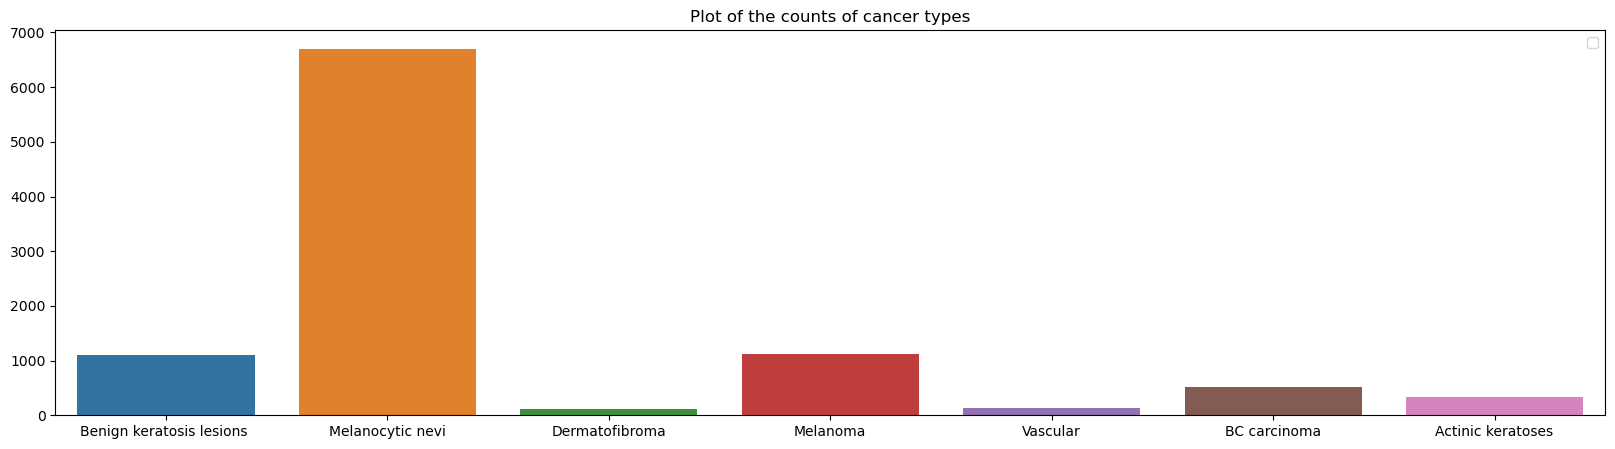

In [13]:
#lets plot the number of counts for cancer types
plt.figure(figsize=(20,5))
sns.countplot(x='dx',data=df)
plt.title("Plot of the counts of cancer types")
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

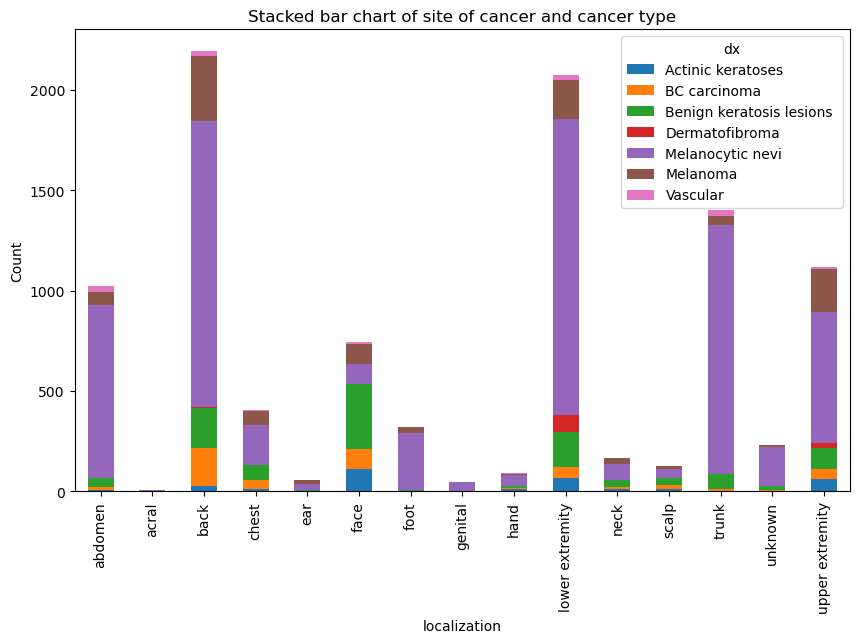

In [14]:
#lets see the freq of cancer rates by age and grouped via sex 
pd.crosstab(df['localization'], df['dx']).plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked bar chart of site of cancer and cancer type')
plt.ylabel('Count')
plt.show()

Looks like based on the number of Melanocytic nevi that there is a clear bias in a sample size. The largest counts of our data have been sampled from patient backs - probably the most common site site melanomas etc - so no surprise there.

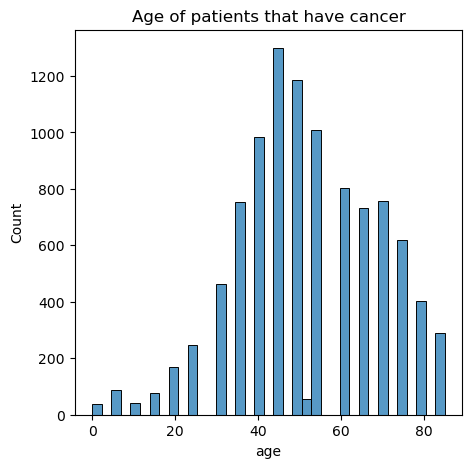

In [15]:
#Lets also look at the age of patients
plt.figure(figsize=(5,5))
sns.histplot(x='age',data=df)
plt.title('Age of patients that have cancer')
plt.show()

In [16]:
df['age'].median(), df['age'].mean()

(50.0, 51.863828077927295)

So mean age = 51.9 years and median age is about 50 years

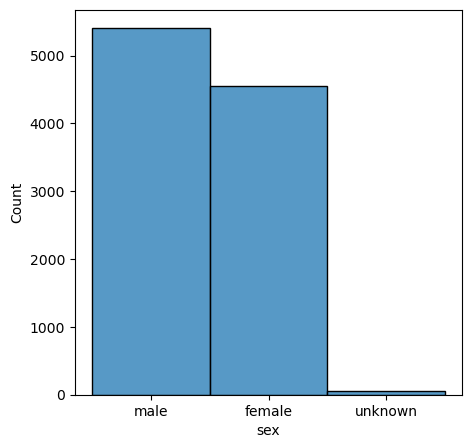

In [16]:
#Lets also look at the sex of patients
plt.figure(figsize=(5,5))
sns.histplot(x='sex',data=df)
plt.show()

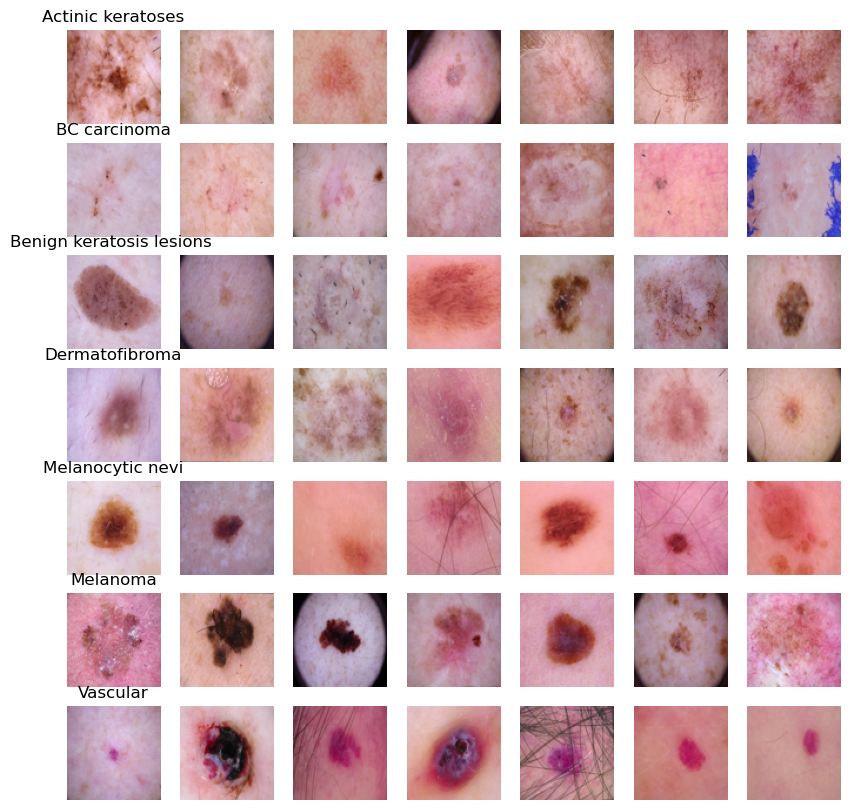

In [17]:
# lets have a look at some cancer affected images
fig, ax = plt.subplots(7,7, figsize=(10,10))
for row_ax, (name,rows) in zip(ax, df.sort_values(by='dx').groupby('dx')):
    row_ax[0].set_title(name)
    for col_ax, (_, cols) in zip(row_ax, rows.sample(7).iterrows()):
        col_ax.imshow(cols['image'])
        col_ax.axis('off')

In [18]:
#normalise images based on pixel size = 255 bit 
df['image'] = df.image.apply(lambda x: x/255)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_dir,image
0,HAM_0000118,ISIC_0027419,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[0.7490196078431373, 0.6, 0.7647058823529411..."
1,HAM_0000118,ISIC_0025030,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[0.09019607843137255, 0.050980392156862744, ..."
2,HAM_0002730,ISIC_0026769,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[0.7294117647058823, 0.5019607843137255, 0.5..."
3,HAM_0002730,ISIC_0025661,Benign keratosis lesions,histo,80.0,male,scalp,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[0.09019607843137255, 0.043137254901960784, ..."
4,HAM_0001466,ISIC_0031633,Benign keratosis lesions,histo,75.0,male,ear,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[0.5294117647058824, 0.3568627450980392, 0.4..."


In [19]:
#encode cancer class labels
class_labels = df['dx'].values
encoder = LabelEncoder()
encoder.fit(class_labels)

LabelEncoder()

In [20]:
encoded_Y = encoder.transform(class_labels)
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [21]:
X = np.asarray(df['image'].tolist())
y = dummy_y
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.125,random_state = 1234)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8763, 80, 80, 3) (8763, 7)
(1252, 80, 80, 3) (1252, 7)


Model 1: Standard CNN 

Here, the incorporation of a CNN architecture with dropout will reduce the likelihood of overfitting by increasing the robustness of network - ie by making neurons redunant. Without relying on the same signals, the model should learn new parameters. 

In [22]:
classes = 7
img_height = 80
img_width = 80

model = Sequential()

model.add(Conv2D(256,(3,3), activation = "relu", input_shape = (img_height, img_width,3)))
model.add(MaxPool2D(pool_size = (2,2)))
#using dropout per recommended ranges - 0.5 - 0.8 is ideal - 500 neurons will randomly be dropped in each iteration
model.add(Dropout(0.5))

model.add(Conv2D(128,(3,3), activation = 'relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), activation = 'relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(32))

model.add(Dense(7,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 39, 39, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 128)       0

In [23]:
# lets complie the CNN
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics = "accuracy")
              
history = model.fit(X_train, y_train, epochs = 40, batch_size = 16, validation_data = (X_test, y_test), verbose = 2)  
model.summary()

Epoch 1/40


2023-08-16 13:05:20.550967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


548/548 - 23s - loss: 1.0056 - accuracy: 0.6693 - val_loss: 0.9637 - val_accuracy: 0.6629 - 23s/epoch - 42ms/step
Epoch 2/40
548/548 - 11s - loss: 0.9410 - accuracy: 0.6755 - val_loss: 0.9089 - val_accuracy: 0.6797 - 11s/epoch - 19ms/step
Epoch 3/40
548/548 - 10s - loss: 0.8996 - accuracy: 0.6823 - val_loss: 0.9544 - val_accuracy: 0.6805 - 10s/epoch - 19ms/step
Epoch 4/40
548/548 - 10s - loss: 0.8564 - accuracy: 0.6911 - val_loss: 0.8680 - val_accuracy: 0.6789 - 10s/epoch - 19ms/step
Epoch 5/40
548/548 - 10s - loss: 0.8172 - accuracy: 0.7049 - val_loss: 0.7924 - val_accuracy: 0.7061 - 10s/epoch - 19ms/step
Epoch 6/40
548/548 - 11s - loss: 0.7821 - accuracy: 0.7156 - val_loss: 0.7864 - val_accuracy: 0.7101 - 11s/epoch - 20ms/step
Epoch 7/40
548/548 - 11s - loss: 0.7661 - accuracy: 0.7174 - val_loss: 0.8243 - val_accuracy: 0.6965 - 11s/epoch - 19ms/step
Epoch 8/40
548/548 - 11s - loss: 0.7606 - accuracy: 0.7226 - val_loss: 0.7791 - val_accuracy: 0.7125 - 11s/epoch - 19ms/step
Epoch 9/40


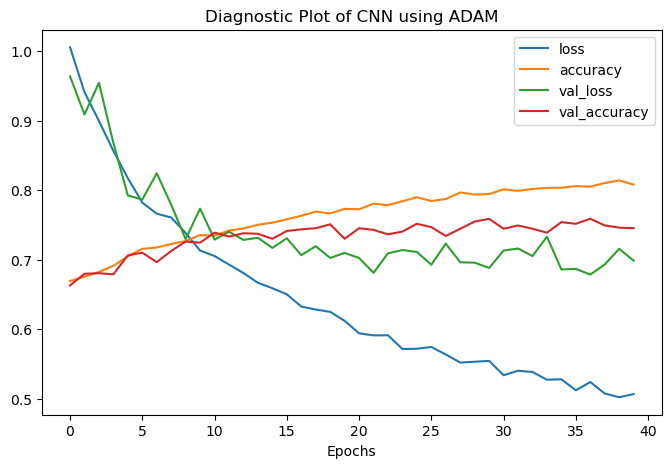

In [36]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Diagnostic Plot of CNN using ADAM")
plt.xlabel("Epochs")
plt.show()

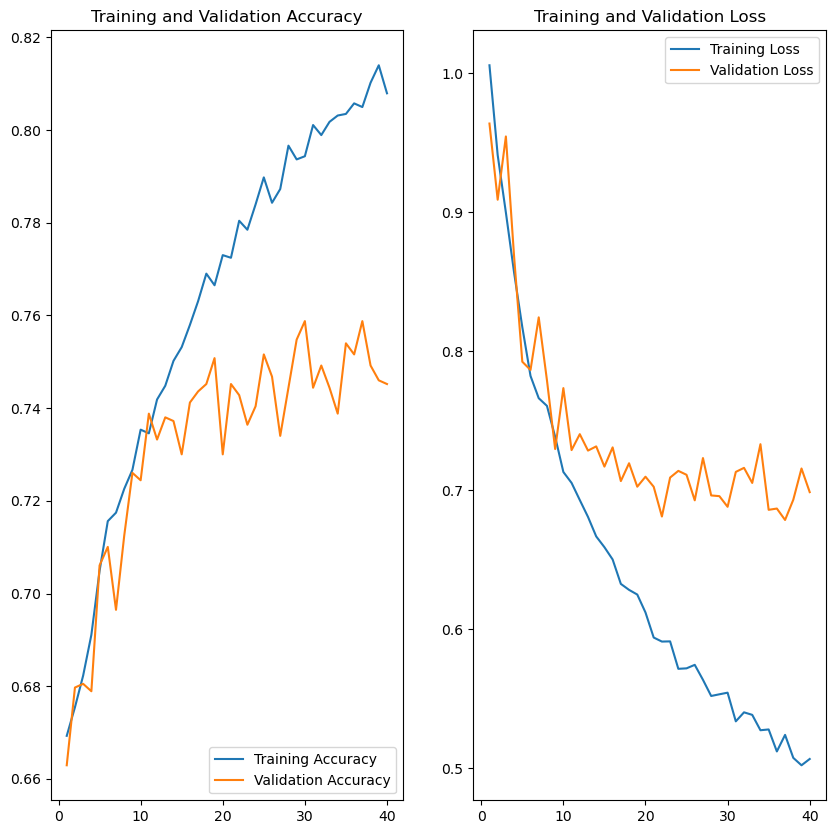

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1,41)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()